In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import quaternion

import itertools

In [2]:
# Step 1: define and verify quaterniton algebra functions, comparing against the quaterion module 

@numba.njit
def qmul(a, b):
    x1, y1, z1, w1 = a
    x2, y2, z2, w2 = b
    return np.array([
        x1*x2 - y1*y2 - z1*z2 - w1*w2,   # x
        x1*y2 + x2*y1 + z1*w2 - w1*z2,   # y
        x1*z2 + x2*z1 + w1*y2 - y1*w2,   # z
        x1*w2 + x2*w1 + y1*z2 - z1*y2    # w
    ])

@numba.njit
def qconj(q):
    x, y, z, w = q
    return np.array([x, -y, -z, -w])


@numba.njit
def qpower(a, n=2):
    r = a.copy()
    for _ in range(n-1):
        r = qmul(r, a)
    return r

@numba.njit
def qmag2(a):
    return qmul(a,qconj(a))[0]


# Test the functions
if True:
    test_points = np.random.randn(100,4)
    #test_points = np.diag([1,1,1,1])

    # Test qmul
    for a, b in itertools.product(test_points, test_points):
        calc_value = qmul(a,b)
        ref_value = (quaternion.from_float_array(a) * quaternion.from_float_array(b)).components
        if not np.isclose(calc_value,ref_value).all():
            print(f"Failed on {a} x {b}. Expected: {ref_value}, got {calc_value} ")
    
    # Test qconj
    for a in test_points:
        calc_value = qconj(a)
        ref_value = quaternion.from_float_array(a).conj().components
        if not np.isclose(calc_value,ref_value).all():
            print(f"Failed on {a} x {b}. Expected: {ref_value}, got {calc_value} ")

    # Test qpower
    for a in test_points:
        for n in range(2,10):
            calc_value = qpower(a,n)
            ref_value = (quaternion.from_float_array(a)**n).components
            if not np.isclose(calc_value,ref_value).all():
                print(f"Failed on {a} x {b}. Expected: {ref_value}, got {calc_value} ")

    # Test qmag2
    for a in test_points:
        calc_value = qmag2(a)
        ref_value = np.abs(quaternion.from_float_array(a))**2
        if not np.isclose(calc_value,ref_value).all():
            print(f"Failed on {a} x {b}. Expected: {ref_value}, got {calc_value} ")



-1.3764561637986594e+30


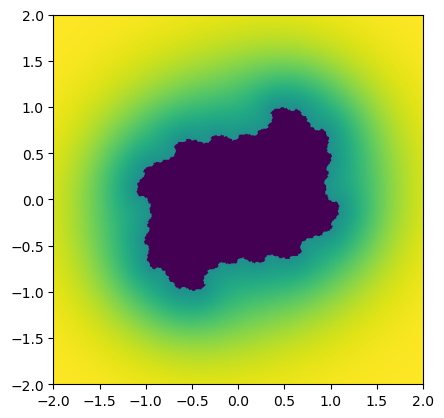

In [ ]:
# Step 2: define and visually verify jit-compiled distance estimator

@numba.njit
def julia_sdf(q, c=[0,0,0,0], n=2, iterations = 50, bailout_level = 10000**2, offset=0):

    q2 = qmag2(q)
    qp2 = 1

    for _ in range(iterations):
        
        q = qpower(q,n) + c
        qp2 = n*n*q2*qp2
        q2 = qmag2(q)

        if q2 > bailout_level:
            break

    dist = np.sqrt(q2/qp2)*0.5*np.log(q2) - offset
    return dist

# Try calling it for one point
print(julia_sdf(
    q = np.array([0.5,0,0,0]),
    c = np.array([0.1,0,0,0])
))

N = 500
x_points = y_points = np.linspace(-2,2,N)
d = np.zeros((N,N))

for i, x in numba.penumerate(x_points):
    for j, y in enumerate(y_points):
        d[i,j] = julia_sdf(
            q = np.array([x,y,0,0]),
            c = np.array([0.2,0.3,0,0]),
            offset = 0
        )

plt.imshow(np.tanh(d), extent=(-2,2,-2,2))

In [ ]:
# Step 3: use sdf machinery to define initial mesh
from skimage.measure import marching_cubes




In [ ]:
# Step 4: refine mesh with Newton's method
